# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 8 апреля 2019, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 8 апреля, -4 балла после 06:00 15 апреля, -6 баллов после 06:00 22 апреля  -8 баллов после 06:00 29 апреля.

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



*** Что почитать по теории ***

Одна из лучших книг по ML $-$ "Pattern Recognition and Machine Learning" Bishop, Christopher. 

Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

$$ \frac{\partial L(w)}{\partial w_k} = -\frac{2}{N}\sum_{i=1}^{N} (y_i - a(x_i))x_i^{(k)}\$$

$$ w_{new} = w_{old} - {\alpha}*grad(L) $$

Где $\alpha$ - шаг спуска

Интуитивно можно описать градиент как вектор средних по батчу вкладов весов в ошибку

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

$$ \frac{\partial L(w)}{\partial w_k} = -\frac{1}{N}\sum_{i=1}^{N} (y_i - a(x_i))x_i^{(k)}\$$

$$ w_{new} = w_{old} - {\alpha}*grad(L) $$

Где $\alpha$ - шаг спуска, $ a(x_i) $ - сигмойда 

Ситуация полностью аналогична случаю линейной регрессии

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией

Есть более приятный подход к проверке точного решения, чем подсчет Гессиана, а именно - в лоб:
$$ Xw = y $$
$$ X^TXw = X^Ty $$
$$ (X^TX)^{-1}X^TXw = (X^TX)^{-1}X^Ty $$
$$w = (X^TX)^{-1}X^Ty $$
Очевидно, что точное решение минимизирует квадратичную ошибку. Справедливым это решение будет как раз тогда, когда у Х строк не меньше, чем столбцов и полный ранг - при этих условиях $(X^TX)$ обратима.

С L2 регуляризацией:
$$ \frac{\partial L(w)}{\partial w_k} = -\frac{2}{N}\sum_{i=1}^{N} (y_i - a(x_i))x_i^{(k)} + \frac{2*w_k}{C} $$
$$ -\frac{2}{N}\sum_{i=1}^{N} (y_i - a(x_i))x_i^{(k)} + \frac{2*w_k}{C} = 0 $$
$$ \frac{1}{N}\sum_{i=1}^{N} (\langle\,x_i,w\rangle - y_i)x_i^{(k)} + \frac{w_k}{C} = 0 $$
Или в матричной формулировке:
$$ \frac{1}{N}X^T(Xw-y) + \frac{w}{C} = 0 $$
$$ X^T(Xw-y) + \frac{N}{C}w = 0 $$
$$ X^TXw-X^Ty + \frac{N}{C}w = 0 $$
$$ (X^TX + \frac{N}{C}I)w = X^Ty $$
$$ (X^TX + \frac{N}{C}I)^{-1}(X^TX + \frac{N}{C}I)w = (X^TX + \frac{N}{C}I)^{-1}X^Ty $$
$$ w = (X^TX + \frac{N}{C}I)^{-1}X^Ty $$

Здесь наглядно видно, как проявляет себя регуляризация - мы отошли от собственных значений матрицы $X^TX$, чем с одной стороны ухудшили решение, а с другой - избавились от плохой обусловленности матрицы и получили более устойчивое решение

Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

$$ \frac{\partial E}{\partial a_i}(L | x_i) = - \frac{p(y_i = 1 | x_i)}{a_i} + \frac{p(y_i = 0 | x_i)}{1 - a_i} = \frac{a_i - p(y_i = 1 | x_i)}{a_i(1 - a_i)}$$

Приравниваем нулю и получаем единственное потенциально оптимальное решение

$$ \frac{\partial E}{\partial a_i}(L | x_i) = \frac{a_i - p(y_i = 1 | x_i)}{a_i(1 - a_i)} = 0 $$

$$ a_i = p(y_i = 1 | x_i) $$

#  Реализация линейной модели (5 баллов) 

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [2]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [3]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [4]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [5]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [6]:
def batch_generator(X, y, shuffle=True, batch_size=1):
    index = np.arange(y.shape[0])
    if shuffle:
        np.random.shuffle(index)
    j = 0
    for i in range(y.shape[0]//batch_size): 
        X_batch = X[index[j:j+batch_size]]
        y_batch = y[index[j:j+batch_size]]
        j+=batch_size
        yield (X_batch, y_batch)

In [7]:
%load_ext pycodestyle_magic

In [8]:
#%%pycodestyle
from sklearn.base import BaseEstimator, ClassifierMixin


def sigmoid(x):
    sigm_value_x = 1/(1+np.exp(-x))
    return sigm_value_x


class MySGDClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, batch_generator, C=1, alpha=0.01,
                 max_epoch=10, model_type='lin_reg',
                 batch_size=50, stop=0.05, th=0.5, warn=True):
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter': [], 'loss': []}
        self.model_type = model_type
        self.batch_size = batch_size
        self.meanerr = []
        self.stop = stop
        self.th = th
        self.warn = warn

    def calc_loss(self, X_batch, y_batch):
        N = y_batch.shape[0]
        ones = np.ones(N).reshape(y_batch.shape)
        X = np.column_stack((ones, X_batch))
        a = np.dot(X, self.weights).reshape(y_batch.shape)  # Prediction
        delta = 0.001
        if self.model_type == 'lin_reg':
            loss = np.dot((a-y_batch).T, (a-y_batch))/N
        else:
            a = sigmoid(a).reshape(y_batch.shape)
            loss = -(np.dot(y_batch.T, np.log(a+delta)) +
                     np.dot((ones-y_batch).T, np.log(ones-a+delta)))/N
        if self.C != 0:
            loss += np.dot(self.weights, self.weights)/self.C  # L2
        return loss

    def calc_loss_grad(self, X_batch, y_batch):
        N = y_batch.shape[0]
        ones = np.ones(N).reshape(y_batch.shape)
        X = np.column_stack((ones, X_batch))
        Xw = np.dot(X, self.weights).reshape(y_batch.shape)
        if self.model_type == 'lin_reg':
            loss_grad = np.dot(-2/N, np.dot(X.T, y_batch-Xw))
        else:
            a = sigmoid(Xw).reshape(y_batch.shape)
            loss_grad = -np.dot(X.T, y_batch - a)/N
        loss_grad = loss_grad.reshape(self.weights.shape)
        if self.C != 0:
            loss_grad += np.dot(2/self.C, self.weights)  # L2 grad
        return loss_grad/np.linalg.norm(loss_grad)

    def update_weights(self, new_grad):
        self.weights -= self.alpha * new_grad

    def fit(self, X, y):
        self.weights = np.random.sample(X.shape[1]+1)
        stepsize = X.shape[0]//self.batch_size
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, True,
                                                       self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                self.update_weights(batch_grad)
            meanerr = np.array(self.errors_log['loss']
                               [n*stepsize:(n+1)*stepsize]).mean()
            self.meanerr.append(meanerr)
            if len(self.meanerr) > 30:
                changes = []
                for i in range(2, 30+2):
                    changes.append(abs(self.meanerr[-1]/self.meanerr[-i]-1))
                count = 0
                for i in changes:
                    if i < self.stop:
                        count += 1
                if count >= 25:  # Ошибка перестала изменяться
                    if self.warn:
                        print('study stop at epoch {0}, model={1}'
                              .format(n, self.model_type))
                    return
                else:
                    count = 0
        return self

    def predict(self, X):
        ones = np.ones(X.shape[0])
        X = np.column_stack((ones, X))
        if self.model_type == 'lin_reg':
            y_hat = np.dot(X, self.weights)
        else:
            if self.th is not None:
                y_hat = np.sign(sigmoid(np.dot(X, self.weights))-self.th)
                y_hat[y_hat == -1] = 0
            else:
                y_hat = sigmoid(np.dot(X, self.weights))
        return y_hat

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [9]:
def plot_decision_boundary(clf, c='green', alp=1):
    w = clf.weights
    x = np.array([-1, 6])
    y = -(w[0] + w[1]*x)/w[2]
    plt.plot(x, y, color=c, alpha=alp, label=clf.model_type)

In [10]:
reg = MySGDClassifier(batch_generator, C=100, alpha=0.01, max_epoch=1000, model_type='lin_reg', batch_size=50, stop=0.001)
log = MySGDClassifier(batch_generator, C=100, alpha=0.01, max_epoch=1000, model_type='log_reg', batch_size=50, stop=0.001)

study stop at epoch 135, model=log_reg
[-1.19751766  0.29162605 -0.32379318]
[-2.30162589  0.63891113 -0.50558539]


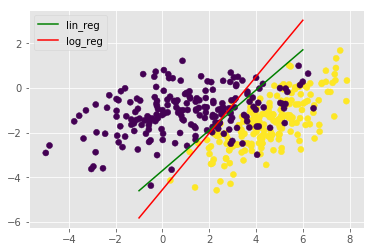

In [11]:
#%%pycodestyle
import copy

np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)


X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]
X1 = np.vstack([gauss1, gauss2])
y1 = np.r_[np.ones(200), np.zeros(200)]

regy = copy.deepcopy(y)
regy[regy == 0] = -1

reg.fit(X, regy)
log.fit(X, y)

plot_decision_boundary(reg)
plot_decision_boundary(log, 'red')

print(reg.weights)
print(log.weights)

plt.legend()
plt.scatter(X[:, 0], X[:, 1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [12]:
from sklearn.datasets import make_classification

In [13]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)
regy = copy.deepcopy(y)
regy[regy==0]=-1

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

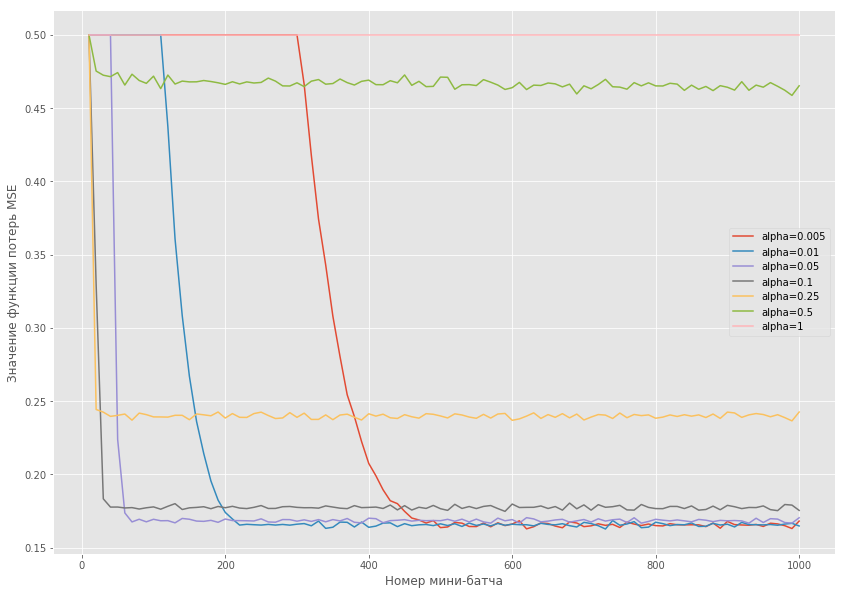

In [14]:
#%%pycodestyle
fig = plt.figure(figsize=(14, 10))
plt.xlabel('Номер мини-батча')
plt.ylabel('Значение функции потерь MSE')
N = 10

for alpha in [0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 1]:
    reg = MySGDClassifier(batch_generator, C=100, alpha=alpha,
                          max_epoch=50, model_type='lin_reg',
                          batch_size=5000, stop=0, warn=False)
    reg.fit(X, regy)
    num = len(reg.errors_log['iter']) // N
    values = [np.mean(reg.errors_log['loss'][i * N: (i + 1) * N])
              for i in range(num)]
    values = np.array(values)
    values[values > 0.5] = 0.5
    steps = []
    for i in range(1, num+1):
        steps += [i*10]
    plt.plot(steps, values, label='alpha={}'.format(alpha))

plt.legend()
plt.show()

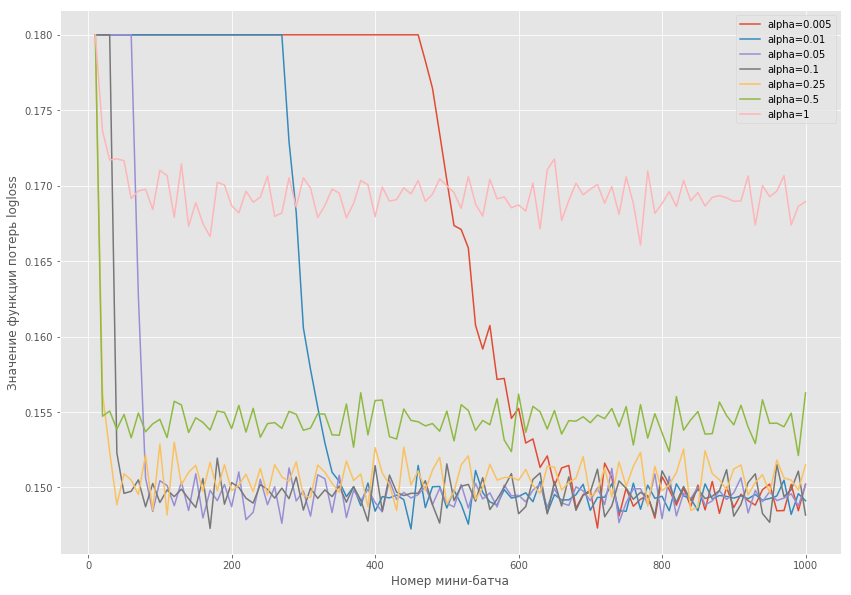

In [15]:
#%%pycodestyle
fig = plt.figure(figsize=(14, 10))
plt.xlabel('Номер мини-батча')
plt.ylabel('Значение функции потерь logloss')
N = 10

for alpha in [0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 1]:
    log = MySGDClassifier(batch_generator, C=100, alpha=alpha,
                          max_epoch=50, model_type='log_reg',
                          batch_size=5000, stop=0, warn=False)
    log.fit(X, y)
    num = len(log.errors_log['iter']) // N
    values = [np.mean(log.errors_log['loss'][i * N: (i + 1) * N])
              for i in range(num)]
    values = np.array(values)
    values[values > 0.18] = 0.18
    steps = []
    for i in range(1, num+1):
        steps += [i*10]
    plt.plot(steps, values, label='alpha={}'.format(alpha))

plt.legend()
plt.show()

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

Для линейной регресси: При alpha < 0.01 - медленная сходимость, при alpha >= 0.05  - быстрая сходимость, но теряется точность. Стоит выбрать значение из [0.01, 0.05] или меньше при необходимости

Для логистической регрессии аналогичная ситуация с диапазоном 0.05 <= alpha <= 0.25

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

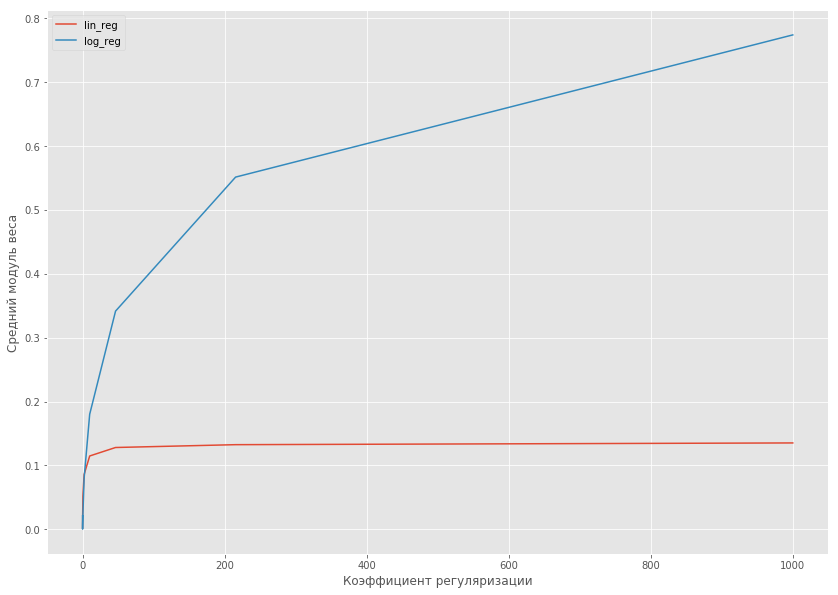

In [17]:
#%%pycodestyle
fig = plt.figure(figsize=(14, 10))
plt.ylabel('Средний модуль веса')
plt.xlabel('Коэффициент регуляризации')
step_length = 10
coef = []
values1 = []
values2 = []
for c in np.logspace(3, -3, 10):
    coef += [c]
    reg = MySGDClassifier(batch_generator, C=c, alpha=0.01, max_epoch=50,
                          model_type='lin_reg', batch_size=5000, warn=False)
    reg.fit(X, regy)
    log = MySGDClassifier(batch_generator, C=c, alpha=0.1, max_epoch=50,
                          model_type='log_reg', batch_size=5000, warn=False)
    log.fit(X, y)
    values1 += [np.abs(reg.weights).mean()]
    values2 += [np.abs(log.weights).mean()]

plt.plot(coef, values1, label='{}'.format('lin_reg'))
plt.plot(coef, values2, label='{}'.format('log_reg'))
plt.legend()
plt.show()

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 

Более-менее да, но слишком больших весов конкретно на этих данных и так не возникало

# Боевое применение (3  балла)

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview-2.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [19]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
print (len(doc_to_title))

28026


In [20]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [21]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15])
X = np.array(X_train)
y = np.array(y_train)
groups_train = np.array(groups_train)

Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [22]:
X = scale(X)

/home/ilya/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

Как? Особенностью задачи можно считать то, что нам нет смысла рассматривать объекты без привязки к группе, но мы эту привязку учли еще на этапе формирования признаков, следовательно никаких проблем на валидации с этим уже не будет

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
#%%pycodestyle
t = time.time()
results = []
splits = 10
kf = KFold(n_splits=splits)
alpha = 0.005

for C in np.logspace(3, -3, 20):
    print('C = ', C)
    reg = MySGDClassifier(batch_generator, C=C, alpha=alpha,
                          max_epoch=1000, model_type='lin_reg',
                          batch_size=1000, stop=0.005, warn=False)
    scores = {}
    for th in [i/1000 for i in range(-1000, 1000)]:
        scores.update({th: 0})
    for train, test in kf.split(X):
        reg.fit(X[train], y[train])
        for th in [i/1000 for i in range(-1000, 1000)]:
            ans = reg.predict(X[test])
            ans[ans < th] = 0
            ans[ans >= th] = 1
            score = f1_score(y[test], ans)
            scores[th] += score
    for th in [i/1000 for i in range(-1000, 1000)]:
        scores[th] /= splits
        results.append({'type': reg.model_type, 'C': C,
                        'th': th, 'score': scores[th]})
print(time.time()-t)

C =  1000.0
C =  483.2930238571752
C =  233.57214690901213
C =  112.88378916846895
C =  54.5559478116852
C =  26.366508987303583
C =  12.742749857031342
C =  6.158482110660267
C =  2.9763514416313193
C =  1.438449888287663
C =  0.6951927961775606
C =  0.33598182862837844
C =  0.16237767391887226
C =  0.07847599703514622
C =  0.037926901907322536
C =  0.018329807108324374
C =  0.008858667904100831
C =  0.004281332398719396
C =  0.00206913808111479
C =  0.001
490.3102548122406


In [28]:
#%%pycodestyle
t = time.time()
splits = 10
kf = KFold(n_splits=splits)
alpha = 0.005

for C in np.logspace(3, -3, 20):
    print('C = ', C)
    log = MySGDClassifier(batch_generator, C=C, alpha=alpha,
                          max_epoch=1000, model_type='log_reg',
                          batch_size=1000, stop=0.005, th=None, warn=False)
    scores = {}
    for th in [i/1000 for i in range(-1000, 1000)]:
        scores.update({th: 0})
    for train, test in kf.split(X):
        log.fit(X[train], y[train])
        for th in [i/1000 for i in range(-1000, 1000)]:
            log.th = th
            ans = log.predict(X[test])
            score = f1_score(y[test], ans)
            scores[th] += score
    for th in [i/1000 for i in range(-1000, 1000)]:
        scores[th] /= splits
        results.append({'type': log.model_type, 'C': C,
                        'th': th, 'score': scores[th]})
print(time.time()-t)

C =  1000.0
C =  483.2930238571752
C =  233.57214690901213
C =  112.88378916846895
C =  54.5559478116852
C =  26.366508987303583
C =  12.742749857031342
C =  6.158482110660267
C =  2.9763514416313193
C =  1.438449888287663
C =  0.6951927961775606
C =  0.33598182862837844
C =  0.16237767391887226
C =  0.07847599703514622
C =  0.037926901907322536
C =  0.018329807108324374
C =  0.008858667904100831
C =  0.004281332398719396
C =  0.00206913808111479
C =  0.001
515.2446036338806


In [33]:
def mykey(set):
    return (set['type'], set['score'])

a = sorted(results, key=mykey, reverse=True)
for i in a[:10]:
    print(i)
print()
for i in a[40000:40010]:
    print(i)

{'type': 'log_reg', 'C': 483.2930238571752, 'th': 0.269, 'score': 0.5857781182509807}
{'type': 'log_reg', 'C': 483.2930238571752, 'th': 0.271, 'score': 0.585531610682527}
{'type': 'log_reg', 'C': 483.2930238571752, 'th': 0.266, 'score': 0.5854867699776803}
{'type': 'log_reg', 'C': 483.2930238571752, 'th': 0.27, 'score': 0.5854089978186648}
{'type': 'log_reg', 'C': 483.2930238571752, 'th': 0.268, 'score': 0.5852311149803279}
{'type': 'log_reg', 'C': 483.2930238571752, 'th': 0.267, 'score': 0.5850702584198779}
{'type': 'log_reg', 'C': 0.07847599703514622, 'th': 0.501, 'score': 0.5848899676223884}
{'type': 'log_reg', 'C': 54.5559478116852, 'th': 0.312, 'score': 0.5847514133445129}
{'type': 'log_reg', 'C': 0.6951927961775606, 'th': 0.492, 'score': 0.5847423823242022}
{'type': 'log_reg', 'C': 2.9763514416313193, 'th': 0.457, 'score': 0.5847198514228535}

{'type': 'lin_reg', 'C': 233.57214690901213, 'th': 0.3, 'score': 0.5869396410634847}
{'type': 'lin_reg', 'C': 233.57214690901213, 'th': 0.

Линейная регрессия показала лучший результат на кросс-валидации, но для красоты еще всё-таки сделаем и логистическую (чтобы никого не обидеть)

In [30]:
r = MySGDClassifier(batch_generator, C=233.57214690901213, alpha=0.005,
                              max_epoch=5000, model_type='lin_reg',
                              batch_size=1000, stop=0.001, th=0.3)
r.fit(X_train, y_train)
an = r.predict(X_test)
an[an>=r.th]=1
an[an<r.th]=0
print(f1_score(y_test, an))
print(precision_score(y_test, an))
print(recall_score(y_test, an))
print(accuracy_score(y_test, an))

0.608809993425378
0.5396270396270396
0.698340874811463
0.7455089820359282


In [31]:
l = MySGDClassifier(batch_generator, C=483.2930238571752, alpha=0.005,
                              max_epoch=5000, model_type='log_reg',
                              batch_size=1000, stop=0.001, th=0.269)
l.fit(X_train, y_train)
ans = l.predict(X_test)
ans[ans>=l.th]=1
ans[ans<l.th]=0
print(f1_score(y_test, ans))
print(precision_score(y_test, ans))
print(recall_score(y_test, ans))
print(accuracy_score(y_test, ans))

0.6073030108904548
0.5278396436525612
0.7149321266968326
0.7378100940975193


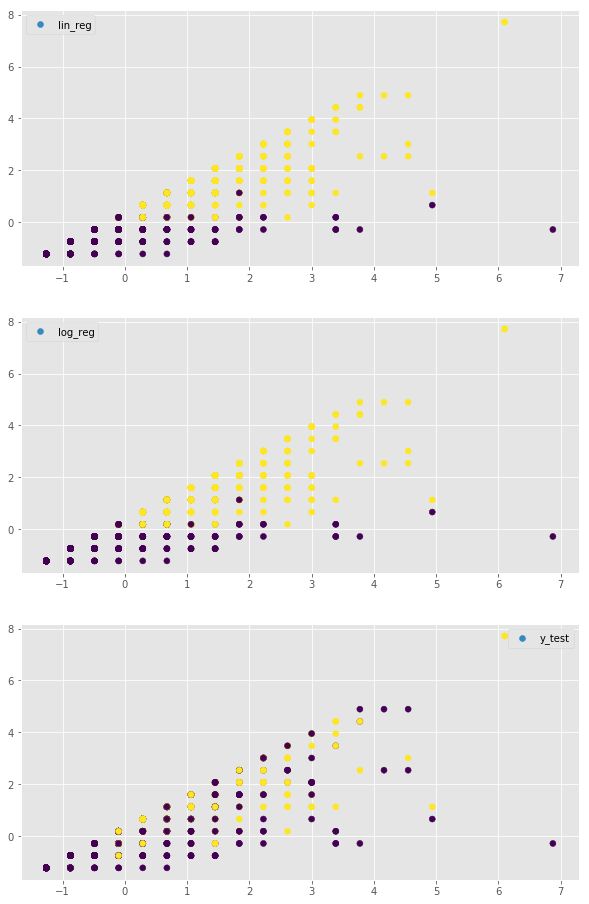

In [32]:
fig = plt.figure(figsize=(10, 16))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312) 
ax3 = fig.add_subplot(313)

ax1.scatter(X_test[:, 0], X_test[:, 1], c=an, label='lin_reg')
ax1.legend()
ax2.scatter(X_test[:, 0], X_test[:, 1], c=ans, label='log_reg')
ax2.legend()
ax3.scatter(X_test[:, 0], X_test[:, 1], c=y_test, label='y_test')
ax3.legend()

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна. Если да, то Вы молодец!

# Контрольные вопросы
Постарайтесь максимально развернуто и честно ответить на вопросы. Они охватывают тему линейных моделей и скорее нужны преподавателям, чтобы понимать, что именно Вы усвоили плохо. Надеюсь, они подскажут, что именно в теме Вы не понимаете или наоборот порадают, что Вы все знаете ^_^

* Опишите основные, на Ваш взгляд,  отличия логистической регрессии от линейной регрессии. Почему, на ваш взгляд, задачу классификации решают логистической, а не линейной регрессией?

Проще в настройке - ответ логистической регрессии дается в виде вероятность, то есть на отрезке [0, 1].

Для линейной регресси в случае классификации не так очевидно, где поставить грань между классами

* Как Вы думаете, для каких типов задач (объем данных, число признаков, типы признаков) стоит отдавать предпочтение линейным моделям?

И обучение, и предсказание относительно быстро происходят на любых объемах данных (особенный плюс для больших данных - мини-батч спуск, нет необходимости хранить все данные в памяти), число признаков тоже в общем случае ничем не ограничено, разве что в случае их высокой коррелированности возникают проблемы с переобучением, которые легко решаются регуляризацией. Типы признаков - любые, но бинарные и категориальные придется закодировать

* Пусть на обучении мы имеем выборку размера $N$, число признаков $D$. Чему равна алгоритмическая сложность одного шага градиентного спуска? Cтохастического градиентного спуска?  Сложность предсказания на одном объекте?

O(ND), O(D) (Матрицу/строку умножаем на вектор, в градиентном спуске умножений в 2 раза больше, чем на предсказании)

* В чем преимущества стохастического градиентного спуска (в том числе мини-батч) над обычным градиентным спуском? В чем его недостатки? Рассмотрите несколько аспектов $-$ скорость сходимости, необходимость загрузки всех данных в оперативную память, сложность вычисления одного шага.

Скорость сходимости выше в контексте времени, ниже в терминах числа шагов. Необходимости загрузки всех данных у мини-батч спуска нет, сложность вычисления одного шага тоже ниже

* Как Вы думаете, при обучении линейной модели с помощью SGD, ошибку на новом объекте стоит считать до итерации спуска на этом объекте или после? Почему Вы так думаете? Возможно, Вам будет интересно ознакомиться с http://hunch.net/~jl/projects/prediction_bounds/thesis/mathml/thesisse44.xml

До итерации, чтобы была возможность учесть ошибку на этой итерации на следующем шаге (как я понял из этой статьи)

* Как Вы думаете, во времена такого бума нейронных сетей, остаются ли популярными линейные модели, или это уже пережиток прошлого? Почему Вы так думаете?

Остаются, потому что их результат легко интерпретируется (объясняется людям, для которых модель создавалась), не все готовы верить черному ящику. + они быстро обучаются

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

Не совсем понимаю, зачем мы пытаемся применить линейную модель к данным, которые изображены чуть выше на рисунке. Тяжело от линейной модели ожидать чего-то хорошего в такой постановке задачи